# Part 2: Data Analytics 
(Raj Dhakan, xn23972)
***
[TODO: insert description of what the code in this file does]
***
## Importing Libraries

In [1]:
import json
import pandas as pd
import requests
import numpy as np
import time
from sigfig import round
# !pip install yfinance
import yfinance as yf
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

## Step 1: Crawling Real-World Datasets
***
The dataset that is extracted is about S&P500 stocks. S&P500 is a common equity indicies which include 500 of the largest companies listed on stock exchanges in the United States. 

First, the table of S&P500 companies is scraped from Wikipedia's __[S&P500 Companies](https://en.wikipedia.org/wiki/List_of_S%26P_500_companies)__ homepage. The columns of interest from this table are: ***Symbol*** of the stock (e.g. AAPL for Apple Inc.), ***Security*** (i.e. the company name), ***Global Industry Classification Standard*** (GICS, i.e. field of work such as Tech, Finance, Healthcare etc) sector, and ***Headquarters Location***. 

Second, common key features used in analysing stocks are scraped from __[Yahoo Finance](https://finance.yahoo.com/)__. The key features of interest are: ***Market Capitilisation***, ***Revenue***, ***Profit Margin***, ***Earning per Share***, ***Profit to Earnings ratio*** and ***Payout Ratio***. These features are scraped by taking the symbols from the table acquired from Wikipedia and using them to create a url to the respective stock's statistics page (e.g. __https://finance.yahoo.com/quote/AAPL/key-statistics?p=AAPL__ for Apple Inc.) Additionaly, a ***Recommendation Score***, ranging from 1 (strong buy) to 5 (strong sell), where 3 is hold, from analysts is also extracted from Yahoo Finance; however, this is achieved by yfinance API. The aim is to relate all other features to S&P500's ***Recommendation Score*** (i.e. whether to buy to to sell) and/or its ranking based on ***Market Capitilisation***.

The two tables are then merged and saved as `SnP500_raw.csv` in the directory of this jupyter notebook

<div class="alert alert-block alert-info">
<b>Note:</b> The data extracted from Yahoo Finance is accurate to date 31/12/2023.
</div>

<div class="alert alert-block alert-danger">
<b>Warning:</b> Running the below code will overwrite the raw_data file.
</div>

In [2]:
# extracting list of SnP 500 companies from Wikipedia
url_link= 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
response = requests.get(url_link)
SnP500_raw = pd.read_html(response.text)[0]
SnP500_raw.head()

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [8]:
def yahoo_api_statistics(symbol:str):
    '''
    Returns a list of features commonly used to evaluate stocks and a recommendation score as per analysts.

            Parameters:
                    symbol (str): Stock symbols; e.g. AAPL for Apple

            Returns:
                    features_list (list): List of key features in the given order:
                    1. Market Capitilisation (Market_cap)
                    2. Revenue (Revenue)
                    3. Profit Margin (Profit_margin)
                    4. Earning per Share (EPS)
                    5. Profit to Earnings ratio (PE_ratio)
                    6. Payout ratio
                    7. Recommendation mean score
    '''  
    # replaces a '.' to '-' in any symbol to produce the correct url to scrape data
    if "." in symbol:
        symbol = symbol.replace(".","-")
        
    statistics_url = ("https://finance.yahoo.com/quote/{symbol}/key-statistics?p={symbol}").format(symbol = symbol)
    response = requests.get(statistics_url, headers= {'User-agent': 'Mozilla/5.0'})
    df = pd.read_html(response.text)
    
    # Extracts individual features from the tables (use of iat over iloc to increase speed of extraction)
    Market_cap = df[0].iat[0,1]
    Revenue = df[-3].iat[0,1]
    Profit_margin = df[5].iat[0,1]
    EPS = df[-3].iat[6,1]
    PE_ratio =  df[0].iat[2,1]
    Payout_ratio = df[3].iat[5,1]
    company = yf.Ticker(symbol)
    try:
        Rec_score = company.get_info()['recommendationMean']
    except:
        Rec_score = None
    
    features_list = [Market_cap, Revenue, Profit_margin, EPS, PE_ratio, Payout_ratio, Rec_score]
    
    return features_list


# creating an empty list to store the features
features = []

# loops through symbols to extract 
for i in range(len(SnP500_raw)):
    
    # try/except to catch out any pages with errors
    try:
        symbol = SnP500_raw.iat[i,0]
        input_list = yahoo_api_statistics(symbol)
        features.append(input_list)
    except:
        print(symbol)

In [9]:
# columns with units, where B = Billions and TTM = Trailing Twelve Months
columns_to_add = ['Market Cap / B', 'Revenue (TTM) / B', 'Profit Margin / %', 'Earnings per Share (TTM) / $', 'Price to Earning ratio (TTM)', 'Payout ratio / %','Recommendation Score']

# converting lists of lists into a dataframe
features = pd.DataFrame(data = features, columns = columns_to_add)

# slicing the raw dataframe to acquire the required columns only 
SnP500_sliced = SnP500_raw[['Symbol','Security','GICS Sector', 'Headquarters Location']]

# merging the two dataframes
SnP500_features_raw = pd.concat([SnP500_sliced,features], axis = 1)

# saving the merged dataframe as csv file in the directory of this Jupyter Notebook
SnP500_features_raw.to_csv("SnP500_raw_data.csv", index= False)

## Step 2: Data Preparation & Cleaning
***
The following is performed sequentially to prepare the data for analysis:
- Column headings are simplified where possible (e.g. ***Security*** is changed to ***Company***) to make it more understandable
- Column ***Headquarters Location*** is split into two columns, ***HQ Country*** and ***HQ State/City***. This because the initial column contain a mix of 'City,State,Country', 'State,Country' and 'City,Country'
- Missing values are identified and quantified for any columns with numeric values to create a logical strategy to clean data
    1. For columns, ***Market Cap***, ***Revenue***, ***Profit Margin***, ***Earnings per Share***, and ***Payout ratio*** any units with the value is removed and then rounded to 2 decimal places
    2. The list of companies is then ordered from the largest to smallest ***Market Cap***
    3. Missing values in ***Price to Earnings ratio*** is filled by calculating from raw data using the formula:
        - `PE = current share price / (sum of EPS over the last 4 quarters)`
    4. ***Price to Earnings ratio*** values have their units removed if any, values are rounded to 2 decimal places, and any incorrect values are corrected (i.e. where PE ratio doesnt share the same sign as EPS, as illustrated by the equation)

In [16]:
# reading csv file
SnP500_raw_file_data = pd.read_csv("SnP500_raw_data.csv")
SnP500_raw_file_data.head()

,Symbol,Security,GICS Sector,Headquarters Location,Market Cap / B,Revenue (TTM) / B,Profit Margin / %,Earnings per Share (TTM) / $,Price to Earning ratio (TTM),Payout ratio / %,Recommendation Score
0,MMM,3M,Industrials,"Saint Paul, Minnesota",60.38B,32.75B,-22.59%,-13.32,16.99,61.67%,NaN
1,AOS,A. O. Smith,Industrials,"Milwaukee, Wisconsin",12.26B,3.8B,7.87%,2.01,41.01,59.70%,2.7
2,ABT,Abbott,Health Care,"North Chicago, Illinois",191.09B,39.96B,12.92%,2.94,37.44,68.03%,2.0
3,ABBV,AbbVie,Health Care,"North Chicago, Illinois",273.61B,55.14B,11.81%,3.66,42.46,160.27%,2.3
4,ACN,Accenture,Information Technology,"Dublin, Ireland",220.02B,64.59B,10.65%,10.77,32.52,43.10%,2.2


In [17]:
# simplify column names
SnP500_columns_renamed = SnP500_raw_file_data.copy()
SnP500_columns_renamed = SnP500_columns_renamed.rename(columns={"Security": "Company", "Headquarters Location": "HQ Country"})
SnP500_columns_renamed.head()

,Symbol,Company,GICS Sector,HQ Country,Market Cap / B,Revenue (TTM) / B,Profit Margin / %,Earnings per Share (TTM) / $,Price to Earning ratio (TTM),Payout ratio / %,Recommendation Score
0,MMM,3M,Industrials,"Saint Paul, Minnesota",60.38B,32.75B,-22.59%,-13.32,16.99,61.67%,NaN
1,AOS,A. O. Smith,Industrials,"Milwaukee, Wisconsin",12.26B,3.8B,7.87%,2.01,41.01,59.70%,2.7
2,ABT,Abbott,Health Care,"North Chicago, Illinois",191.09B,39.96B,12.92%,2.94,37.44,68.03%,2.0
3,ABBV,AbbVie,Health Care,"North Chicago, Illinois",273.61B,55.14B,11.81%,3.66,42.46,160.27%,2.3
4,ACN,Accenture,Information Technology,"Dublin, Ireland",220.02B,64.59B,10.65%,10.77,32.52,43.10%,2.2


In [18]:
# identify which columns have missing values and how many
print(SnP500_columns_renamed.isna().sum())

# as such columns 'Price to Earning ratio' will be cleaned last

Symbol                           0
Company                          0
GICS Sector                      0
HQ Country                       0
Market Cap / B                   0
Revenue (TTM) / B                0
Profit Margin / %                0
Earnings per Share (TTM) / $     0
Price to Earning ratio (TTM)    20
Payout ratio / %                 0
Recommendation Score             4
dtype: int64


In [19]:
# HQ country column to contain countries only

# scraping all American states from Wikipedia
url_link = 'https://en.wikipedia.org/wiki/List_of_states_and_territories_of_the_United_States'
response = requests.get(url_link)
american_states = pd.read_html(response.text)[1].iloc[:,0]

# cleaning data fetched from Wikipedia
american_states = list(american_states.str.rstrip(to_strip="[B]"))
print(american_states)

# indentifying unique countries/states, and duplication
unique_states_countries = set([location.split(',')[-1].strip() for location in list(SnP500_columns_renamed.iloc[:,3])])  
print(unique_states_countries)

# creating a copy of dataframe where HQ location data can be cleaned 
SnP500_HQ_location_cleaned = SnP500_columns_renamed.copy()

# creating empty list to store the states or city extracted from the HQ location column
state_or_city = []

# looping through the HQ Country column and changing values individually
for i in range(len(SnP500_columns_renamed)):
    
    location = (SnP500_columns_renamed.iat[i,3]).split(',')[-1].strip()
    
    if (location in american_states) or (location == "D.C."):
        
        SnP500_HQ_location_cleaned.iat[i,3] = "United States"
    
        if location == "D.C.":
            state_or_city.append("Washington")
        else:
            state_or_city.append(location)
            
    elif location == "UK":
        
        SnP500_HQ_location_cleaned.iat[i,3] = "United Kingdom"
        state_or_city.append(((SnP500_columns_renamed.iat[i,3]).split(',')[-2]).strip())
    
    else:
        
        SnP500_HQ_location_cleaned.iat[i,3] = location
        state_or_city.append(((SnP500_columns_renamed.iat[i,3]).split(',')[-2]).strip())

# converting list to pandas Dataframe
state_or_city = pd.DataFrame(data = state_or_city)

# inserting Dataframe to the main dataset
SnP500_HQ_location_cleaned.insert(loc = 4, value = state_or_city, column = "HQ State/City")

# saving as csv to for reference and checking entire dataset
SnP500_HQ_location_cleaned.to_csv("tests/test1_HQ_Location.csv", index= False)

['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']
{'Kentucky', 'Alabama', 'Arkansas', 'Nebraska', 'Bermuda', 'Utah', 'Louisiana', 'Connecticut', 'California', 'Ireland', 'UK', 'North Carolina', 'Nevada', 'New Jersey', 'Delaware', 'Pennsylvania', 'Wisconsin', 'Massachusetts', 'Tennessee', 'Florida', 'Maryland', 'United Kingdom', 'Maine', 'Colorado', 'Canada', 'New York', 'Netherlands', 'Missouri', 'Switzerland', 'Iowa', 'Ind

In [20]:
# checking head data
SnP500_HQ_location_cleaned.head()

,Symbol,Company,GICS Sector,HQ Country,HQ State/City,Market Cap / B,Revenue (TTM) / B,Profit Margin / %,Earnings per Share (TTM) / $,Price to Earning ratio (TTM),Payout ratio / %,Recommendation Score
0,MMM,3M,Industrials,United States,Minnesota,60.38B,32.75B,-22.59%,-13.32,16.99,61.67%,NaN
1,AOS,A. O. Smith,Industrials,United States,Wisconsin,12.26B,3.8B,7.87%,2.01,41.01,59.70%,2.7
2,ABT,Abbott,Health Care,United States,Illinois,191.09B,39.96B,12.92%,2.94,37.44,68.03%,2.0
3,ABBV,AbbVie,Health Care,United States,Illinois,273.61B,55.14B,11.81%,3.66,42.46,160.27%,2.3
4,ACN,Accenture,Information Technology,Ireland,Dublin,220.02B,64.59B,10.65%,10.77,32.52,43.10%,2.2


In [21]:
# checking data types of numeric columns (from Market Cap onwards) and to see if they may contain any units
SnP500_HQ_location_cleaned.info()

# based on this column Earnings per Share and Recommendation Score contains only numeric, and therefore only
# needs to be rounded to 2 decimal places, and the rest of the columns may contain units and or nan values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 503 entries, 0 to 502
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Symbol                        503 non-null    object 
 1   Company                       503 non-null    object 
 2   GICS Sector                   503 non-null    object 
 3   HQ Country                    503 non-null    object 
 4   HQ State/City                 503 non-null    object 
 5   Market Cap / B                503 non-null    object 
 6   Revenue (TTM) / B             503 non-null    object 
 7   Profit Margin / %             503 non-null    object 
 8   Earnings per Share (TTM) / $  503 non-null    float64
 9   Price to Earning ratio (TTM)  483 non-null    object 
 10  Payout ratio / %              503 non-null    object 
 11  Recommendation Score          499 non-null    float64
dtypes: float64(2), object(10)
memory usage: 47.3+ KB


In [30]:
# creating a copy of dataframe where values for 'Market Cap', 'Revenue' and Profit Margin' can be cleaned 
SnP500_units_cleaned = SnP500_HQ_location_cleaned.copy()

# checking for different units in columns Market Cap and Revenue
units_market_cap = set(SnP500_units_cleaned['Market Cap / B'].str.slice(-1))
units_revenue = set(SnP500_units_cleaned['Revenue (TTM) / B'].str.slice(-1))
units_profit_margin = set(SnP500_units_cleaned['Profit Margin / %'].str.slice(-1))
units_payout_ratio = set(SnP500_units_cleaned['Payout ratio / %'].str.slice(-1))
print(units_market_cap)
print(units_revenue)
print(units_profit_margin)
print(units_payout_ratio)

# based on this all three columns need to have the units removed and rounded to 2 decimal places, and EPS column only needs 
# to be rounded to 2 decimal places

SnP500_units_cleaned['Payout ratio / %'] = [(str(i).replace(",", "")) for i in SnP500_units_cleaned['Payout ratio / %']]

# iterating through all rows of data and adjusting values for all four columns
for i in range(len(SnP500_units_cleaned)):
    
    SnP500_units_cleaned.iat[i,7] = round(float(SnP500_units_cleaned.iat[i,7][:-1]), decimals=2)
    SnP500_units_cleaned.iat[i,8] = round(float(SnP500_units_cleaned.iat[i,8]), decimals=2)
    SnP500_units_cleaned.iat[i,10] = round(float(SnP500_units_cleaned.iat[i,10][:-1]), decimals=2)
    
    if SnP500_units_cleaned.iat[i,5][-1]=="T":
        SnP500_units_cleaned.iat[i,5] = round(float(SnP500_units_cleaned.iat[i,5][:-1])*1000, decimals=2)
    else:
        SnP500_units_cleaned.iat[i,5] = round(float(SnP500_units_cleaned.iat[i,5][:-1]), decimals=2)
        
    
    if SnP500_units_cleaned.iat[i,6][-1]=="M":
        SnP500_units_cleaned.iat[i,6] = round(float(SnP500_units_cleaned.iat[i,6][:-1])/1000, decimals=2)
    else:
        SnP500_units_cleaned.iat[i,6] = round(float(SnP500_units_cleaned.iat[i,6][:-1]), decimals=2)

# saving as csv to for reference and checking entire dataset
SnP500_units_cleaned.to_csv("tests/test2_Standardising_Units.csv", index= False)

{'T', 'B'}
{'M', 'B'}
{'%'}
{'%'}


In [31]:
# checking head data
SnP500_units_cleaned.head()

,Symbol,Company,GICS Sector,HQ Country,HQ State/City,Market Cap / B,Revenue (TTM) / B,Profit Margin / %,Earnings per Share (TTM) / $,Price to Earning ratio (TTM),Payout ratio / %,Recommendation Score
0,MMM,3M,Industrials,United States,Minnesota,60.38,32.75,-22.59,-13.32,16.99,61.67,NaN
1,AOS,A. O. Smith,Industrials,United States,Wisconsin,12.26,3.8,7.87,2.01,41.01,59.7,2.7
2,ABT,Abbott,Health Care,United States,Illinois,191.09,39.96,12.92,2.94,37.44,68.03,2.0
3,ABBV,AbbVie,Health Care,United States,Illinois,273.61,55.14,11.81,3.66,42.46,160.27,2.3
4,ACN,Accenture,Information Technology,Ireland,Dublin,220.02,64.59,10.65,10.77,32.52,43.1,2.2


In [32]:
# create a copy to arrange companies based on market capitalisation
SnP500_sorted = SnP500_units_cleaned.copy()

# ordering the companys based on largest 'Market Cap' to the smallest, and readjusting the index values to reflect ranking
SnP500_sorted = SnP500_sorted.sort_values("Market Cap / B", ascending = False, ignore_index=True)

# checking head data
SnP500_sorted.head()

,Symbol,Company,GICS Sector,HQ Country,HQ State/City,Market Cap / B,Revenue (TTM) / B,Profit Margin / %,Earnings per Share (TTM) / $,Price to Earning ratio (TTM),Payout ratio / %,Recommendation Score
0,AAPL,Apple Inc.,Information Technology,United States,California,2990.0,383.29,25.31,6.12,31.40,15.33,2.1
1,MSFT,Microsoft,Information Technology,United States,Washington,2790.0,218.31,35.31,10.30,36.44,26.36,1.7
2,GOOGL,Alphabet Inc. (Class A),Communication Services,United States,California,1760.0,297.13,22.46,5.23,26.76,0.0,1.9
3,GOOG,Alphabet Inc. (Class C),Communication Services,United States,California,1760.0,297.13,22.46,5.22,27.01,0.0,1.7
4,AMZN,Amazon,Consumer Discretionary,United States,Washington,1570.0,554.03,3.62,1.91,79.55,0.0,1.7


In [33]:
# saving as csv to for reference and checking entire dataset
SnP500_sorted.to_csv("tests/test3_Market_Cap_Ordering.csv", index= False)

In [34]:
# ensuring data quality maintained by checking on null values
print(SnP500_sorted.isna().sum())

Symbol                           0
Company                          0
GICS Sector                      0
HQ Country                       0
HQ State/City                    0
Market Cap / B                   0
Revenue (TTM) / B                0
Profit Margin / %                0
Earnings per Share (TTM) / $     0
Price to Earning ratio (TTM)    20
Payout ratio / %                 0
Recommendation Score             4
dtype: int64


In [36]:
# filling out missing PE ratios with raw data from Yahoo finance

# finding out which companies have missing PE ratios
companies_with_no_PE_ratios = list(SnP500_sorted['Symbol'][SnP500_sorted['Price to Earning ratio (TTM)'].isna()])
print(companies_with_no_PE_ratios)

# creating a function which utilises functions from yfinance python library
# (https://github.com/ranaroussi/yfinance/tree/main) to extract EPS data from quartery income statement and current share
# price
def yahoo_finance_PE_ratio(symbol:str):
    '''
    Returns Profit to Earnings ratio.

            Parameters:
                    symbol (str): Stock symbols; e.g. AAPL for Apple

            Returns:
                    Profit to Earnings ratio (float): calculated by dividing current share price 
                    by the sum of EPS over the last 4 quarters
    '''  
    company = yf.Ticker(symbol)
    PE_ratio = (company.info['currentPrice'])/(company.quarterly_income_stmt.iloc[20,0:4].sum())
    return PE_ratio 

# iterating through the list of companies with no PE_ratio and using the function to calculate it
for company in companies_with_no_PE_ratios:
    PE_ratio = yahoo_finance_PE_ratio(company)
    index = SnP500_sorted.index[SnP500_sorted['Symbol']==company]
    SnP500_sorted.iat[index[0],9] = round(PE_ratio, decimals=2)

['INTC', 'BA', 'T', 'MET', 'ALL', 'FIS', 'WBD', 'TTWO', 'ILMN', 'TSN', 'STX', 'WDC', 'SWK', 'SJM', 'AES', 'NRG', 'QRVO', 'PARA', 'BIO', 'CTLT']


In [37]:
# checking that there are no missing PE_ratios anymore
print(SnP500_sorted.isna().sum())

Symbol                          0
Company                         0
GICS Sector                     0
HQ Country                      0
HQ State/City                   0
Market Cap / B                  0
Revenue (TTM) / B               0
Profit Margin / %               0
Earnings per Share (TTM) / $    0
Price to Earning ratio (TTM)    0
Payout ratio / %                0
Recommendation Score            4
dtype: int64


In [38]:
# checking head data
SnP500_sorted.head()

,Symbol,Company,GICS Sector,HQ Country,HQ State/City,Market Cap / B,Revenue (TTM) / B,Profit Margin / %,Earnings per Share (TTM) / $,Price to Earning ratio (TTM),Payout ratio / %,Recommendation Score
0,AAPL,Apple Inc.,Information Technology,United States,California,2990.0,383.29,25.31,6.12,31.40,15.33,2.1
1,MSFT,Microsoft,Information Technology,United States,Washington,2790.0,218.31,35.31,10.30,36.44,26.36,1.7
2,GOOGL,Alphabet Inc. (Class A),Communication Services,United States,California,1760.0,297.13,22.46,5.23,26.76,0.0,1.9
3,GOOG,Alphabet Inc. (Class C),Communication Services,United States,California,1760.0,297.13,22.46,5.22,27.01,0.0,1.7
4,AMZN,Amazon,Consumer Discretionary,United States,Washington,1570.0,554.03,3.62,1.91,79.55,0.0,1.7


In [39]:
# given that there are no missing PE_ratios, now checking for any units in Price to Earnings column
units_pe = set(SnP500_sorted['Price to Earning ratio (TTM)'].str.slice(-1))
print(units_pe)

{nan, '1', '9', '7', 'k', '8', '0', '6', '4', '5', '3', '2'}


In [41]:
# as such there are some values with unit 'k' which need removing and rounding values to 2 decimal places
for i in range(len(SnP500_sorted)):

    if type(SnP500_sorted.iat[i,9])==str:
        if SnP500_sorted.iat[i,9][-1]=='k':
            SnP500_sorted.iat[i,9] = round(float(SnP500_sorted.iat[i,9][:-1]), decimals=2)

In [45]:
# filling out Recommendation Score with mean value
mean_Rec_score = SnP500_sorted['Recommendation Score'].mean(axis=0)
print(mean_Rec_score)
SnP500_sorted['Recommendation Score'] =  SnP500_sorted['Recommendation Score'].fillna(round(mean_Rec_score, decimals=1))

2.314428857715431


In [46]:
# changing data types to float for numeric columns
SnP500_sorted[['Market Cap / B', 'Revenue (TTM) / B', 'Profit Margin / %', 'Earnings per Share (TTM) / $', 'Price to Earning ratio (TTM)', 'Payout ratio / %', 'Recommendation Score']] = SnP500_sorted[['Market Cap / B', 'Revenue (TTM) / B', 'Profit Margin / %', 'Earnings per Share (TTM) / $', 'Price to Earning ratio (TTM)', 'Payout ratio / %', 'Recommendation Score']].astype(float)

In [47]:
# checking for data type conversion
SnP500_sorted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 503 entries, 0 to 502
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Symbol                        503 non-null    object 
 1   Company                       503 non-null    object 
 2   GICS Sector                   503 non-null    object 
 3   HQ Country                    503 non-null    object 
 4   HQ State/City                 503 non-null    object 
 5   Market Cap / B                503 non-null    float64
 6   Revenue (TTM) / B             503 non-null    float64
 7   Profit Margin / %             503 non-null    float64
 8   Earnings per Share (TTM) / $  503 non-null    float64
 9   Price to Earning ratio (TTM)  503 non-null    float64
 10  Payout ratio / %              503 non-null    float64
 11  Recommendation Score          503 non-null    float64
dtypes: float64(7), object(5)
memory usage: 47.3+ KB


In [48]:
# saving as csv to for reference and checking entire dataset
SnP500_sorted.to_csv("tests/test4_No_Null_values.csv", index= False)

In [49]:
# as per the formula, the correctness of PE ratio can be determined by comparing its sign with EPS
# so PE ratio must have the same sign as EPS, else the value for PE ratio is incorrect 

incorrect_values_for_PE = list(SnP500_sorted['Symbol'][(SnP500_sorted['Price to Earning ratio (TTM)']>0) & (SnP500_sorted['Earnings per Share (TTM) / $']<0)])
incorrect_values_for_PE_2 = list(SnP500_sorted['Symbol'][(SnP500_sorted['Price to Earning ratio (TTM)']<0) & (SnP500_sorted['Earnings per Share (TTM) / $']>0)])
print(incorrect_values_for_PE)
print(incorrect_values_for_PE_2)

# based on this there are values where PE ratios is positive and EPS value is negative

['MU', 'MMM', 'NEM', 'MRNA', 'CCL', 'WBA', 'WRK', 'NCLH', 'XRAY', 'VFC', 'HAS', 'WHR', 'MHK']
[]


In [52]:
# fixing PE values by calculating it from raw data
for company in incorrect_values_for_PE:
    PE_ratio = yahoo_finance_PE_ratio(company)
    index = SnP500_sorted.index[SnP500_sorted['Symbol']==company]
    SnP500_sorted.iat[index[0],9] = round(PE_ratio, decimals=2)

In [53]:
# checking for all values to be accurate and consistent
SnP500_sorted.info()
print(SnP500_sorted.isna().sum())
incorrect_values_for_PE = list(SnP500_sorted['Symbol'][(SnP500_sorted['Price to Earning ratio (TTM)']>0) & (SnP500_sorted['Earnings per Share (TTM) / $']<0)])
print(incorrect_values_for_PE)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 503 entries, 0 to 502
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Symbol                        503 non-null    object 
 1   Company                       503 non-null    object 
 2   GICS Sector                   503 non-null    object 
 3   HQ Country                    503 non-null    object 
 4   HQ State/City                 503 non-null    object 
 5   Market Cap / B                503 non-null    float64
 6   Revenue (TTM) / B             503 non-null    float64
 7   Profit Margin / %             503 non-null    float64
 8   Earnings per Share (TTM) / $  503 non-null    float64
 9   Price to Earning ratio (TTM)  503 non-null    float64
 10  Payout ratio / %              503 non-null    float64
 11  Recommendation Score          503 non-null    float64
dtypes: float64(7), object(5)
memory usage: 47.3+ KB
Symbol          

In [55]:
# creating a copy with new label to identify as clean dataset
SnP500_final_cleaned = SnP500_sorted.copy()

# saving cleaned dataset as csv
SnP500_final_cleaned.to_csv("tests/test5_SnP500_final_cleaned.csv", index= False)

## Step 3: Exploratory Analysis and Step 4: Investigating Data-Set with questions
***


In [73]:
# reading data from csv with clean data
SnP500_final_cleaned = pd.read_csv("SnP500_final_cleaned.csv")

# setting default parameters for plots
%matplotlib inline
plt.style.use("seaborn-v0_8")
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['figure.figsize'] = (10, 5)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

### Columns: Symbol & Company

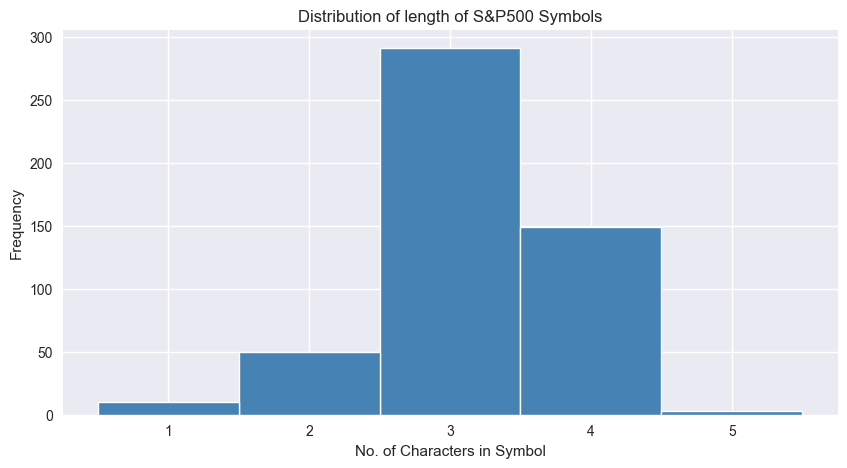

In [74]:
# exploring distribution of length of each symbol in S&P500 companies
symbol_length = SnP500_final_cleaned.Symbol.str.len()
x = symbol_length.value_counts().index.array
y = symbol_length.value_counts().array

# plotting bar chart with distribution with symbol length
fig, ax = plt.subplots()
ax.bar(x, y, width=1, edgecolor="white", color = "steelblue", linewidth=1)
ax.set_xticks([1,2,3,4,5])
ax.set_xlabel("No. of Characters in Symbol")
ax.set_ylabel("Frequency")
plt.title("Distribution of length of S&P500 Symbols")
plt.show()

In [75]:
# code to identify any symbols which may contain special characters or numbers
symbol_isalpha = SnP500_final_cleaned.Symbol.str.isalpha()
print(symbol_isalpha.value_counts())
print(SnP500_final_cleaned['Symbol'][symbol_isalpha==False])

Symbol
True     501
False      2
Name: count, dtype: int64
8      BRK.B
281     BF.B
Name: Symbol, dtype: object


As seen in the above figure, most S&P500 companies have symbol with 3 characters and ocassionaly rising up to 4. The maximum and minimum characters they can have are 5 and 1 respectively; however, very few companies fall into these extremes.

Moreover, most of S&P500 companies have a symbol made from alphabetical characters only. The 2 outliers which include a
period within the symbol are Berkshire Hathaway and Brown-Forman.

In [76]:
# checking if company names are unique
unique_companies = SnP500_final_cleaned.Company.nunique()
if unique_companies == len(SnP500_final_cleaned):
    print("All companies are unique")
else:
    print("There are duplicate company records")

All companies are unique


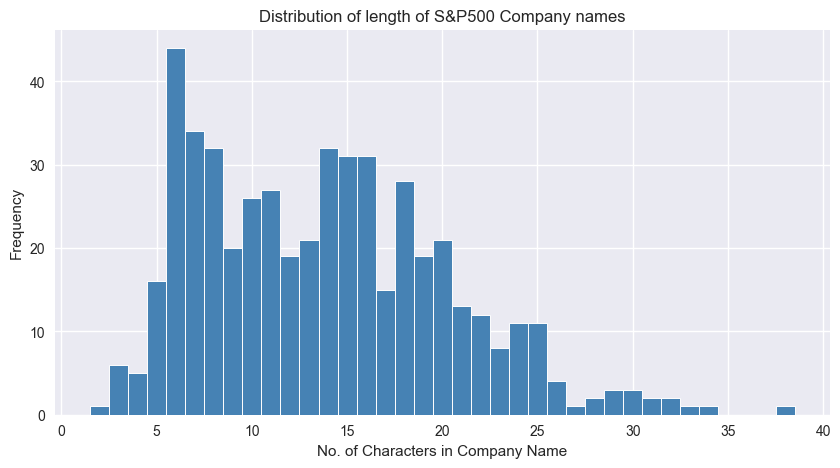

In [77]:
# plotting bar chart with distribution of company name length
name_length = SnP500_final_cleaned.Company.str.len()
x = name_length.value_counts().index.array
y = name_length.value_counts().array
fig, ax = plt.subplots()
ax.bar(x, y, width=1, edgecolor="white", color = "steelblue", linewidth=0.7)
ax.set_xlabel("No. of Characters in Company Name")
ax.set_ylabel("Frequency")
plt.title("Distribution of length of S&P500 Company names")
plt.show()

In [78]:
# statistics for company name length
SnP500_final_cleaned.Company.str.len().describe()

count    503.000000
mean      13.757455
std        6.486641
min        2.000000
25%        8.000000
50%       14.000000
75%       18.000000
max       38.000000
Name: Company, dtype: float64

As seen in the above, all S&P500 company names are unique. From the figure above, the distribution of the company name length looks to be positively skewed, with most frequent name length to be 6 characters and an mean length just above 13. This implies that S&P500 company names tend to be shorter in general.
***
The above analysis leads to the first question:
#### <font color=red>1. Is the length of a S&P500 company symbol and name correlated to the recommendation score of analysts?</font>

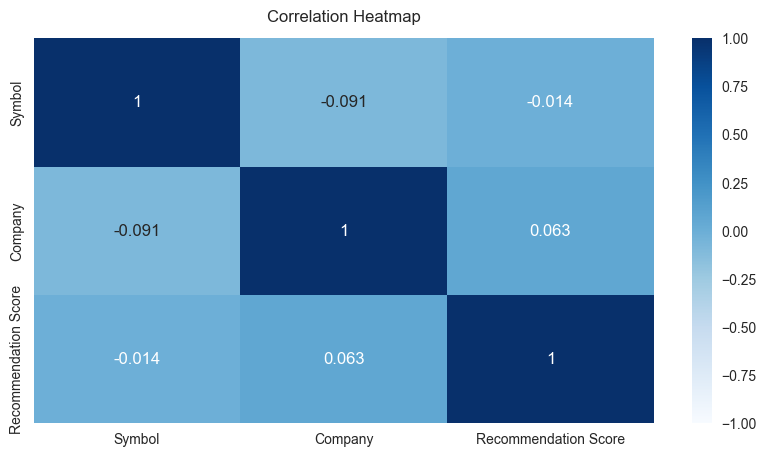

In [89]:
data = pd.concat([symbol_length.to_frame(),name_length.to_frame(),SnP500_final_cleaned['Recommendation Score']], axis =1)
data.corr()
plt.figure(figsize=(10, 5))
sns.color_palette("Blues", as_cmap=True)
heatmap = sns.heatmap(data.corr(), vmin=-1, vmax=1, annot=True, cmap = "Blues")
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

### Columns: GICS Sector, HQ Country & HQ City/State

Number of unique GISC: 11


Text(0, 0.5, '')

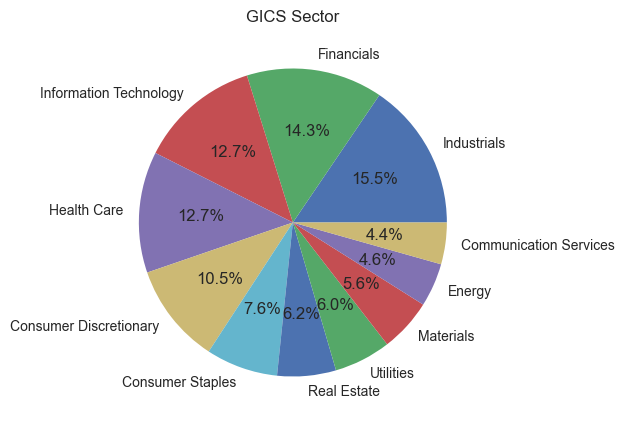

In [7]:
# exploring distribution GISC Sector and percentages
print(f"Number of unique GISC: {SnP500_final_cleaned['GICS Sector'].nunique()}")
fig, ax = plt.subplots()
SnP500_final_cleaned['GICS Sector'].value_counts().plot.pie(autopct='%1.1f%%')
ax.set_title('GICS Sector')
ax.set_ylabel('')

As seen in the above figure, the top 5 GICS sectors with the most S&P500 companies include Industrials, Financials, Information Technology, Health Care and Consumer Discretionary. It is expected that Industrials and Information Technology would have the most S&P500 companies as a result of acquiring wealth share from the 2nd and 3rd Industrial revolutions. With advances in Healthcare services in general, it is no surprise to see that it is in the top 5 GICS sectors. Consumer Discretionary involves business most senstive to economic cycles; for products it includes items such household durable goods and textiles/apparel and for services it includes leisure, hotels, restaurants etc. With the rise in entertainment and increasing emphasis on fashion, this is an industry which would be expected to contain some of the top S&P500 companies.

In [14]:
# distribution of HQ Countries and percentages
print(f"Number of unique HQ Countries: {SnP500_final_cleaned['HQ Country'].nunique()}")
unique_HQ_Country = pd.Series(SnP500_final_cleaned['HQ Country'].value_counts(), name="Count")
percentage = pd.Series((unique_HQ_Country/unique_HQ_Country.sum())*100, name="Percentage")
df = pd.concat([unique_HQ_Country,percentage], axis=1)
df.round(2).style.background_gradient(cmap='GnBu')

Number of unique HQ Countries: 7


,Count,Percentage
HQ Country,,
United States,481,95.630000
Ireland,9,1.790000
United Kingdom,5,0.990000
Switzerland,3,0.600000
Netherlands,2,0.400000
Bermuda,2,0.400000
Canada,1,0.200000


As seen in the above table, 95% of all S&P500 companies have HQ located in the United States which as expected. However, Ireland and the United Kingdom have combined majority of almost 3%. Companies located in Ireland could be because Ireland is considered as a 'tax haven' for large corporation in addition, the time zone difference to the States is not too different that work can be carried in sync. Companies located in the UK, could be also due to the time zone, but also because London is considered as one of the main financial hubs of the world, which could make it easy to access money when having large projects. 

In [15]:
# distribution of HQ State/City and percentages
print(f"Number of unique HQ States/Cities: {SnP500_final_cleaned['HQ State/City'].nunique()}")
unique_HQ_StateCity = SnP500_final_cleaned['HQ State/City'].value_counts()
percentage = pd.Series((unique_HQ_StateCity/unique_HQ_StateCity.sum())*100, name="Percentage")
df = pd.concat([unique_HQ_StateCity,percentage], axis=1)
df.round(2).head(10).style.background_gradient(cmap='GnBu')

Number of unique HQ States/Cities: 50


,count,Percentage
HQ State/City,,
California,69,13.720000
New York,52,10.340000
Texas,47,9.340000
Illinois,33,6.560000
Massachusetts,23,4.570000
Ohio,20,3.980000
Pennsylvania,19,3.780000
Georgia,18,3.580000
Florida,17,3.380000


As seen in the above table the top 10 HQ locations for S&P500 companies are in the United States, with the top 3 states being California, New York and Texas. The 3 states are expected because Silicon Valley is located in California and hence many tech and financial companies would be located there to access of skilled worker and resources. Many of the S&P500 companies, especially in financial sector, would be located in New York due historical reasons such as: access to skilled workers, access to capital, good transportation, networking opportunities. Texas is also another 'tax haven' for corporations and their founders, hence many big companies would be expected to locate there.

This leads to the second questions:
#### <font color=red>2. Which HQ countries of S&P500 dominate each of GICS Sector?</font>

(0.0, 100.0)

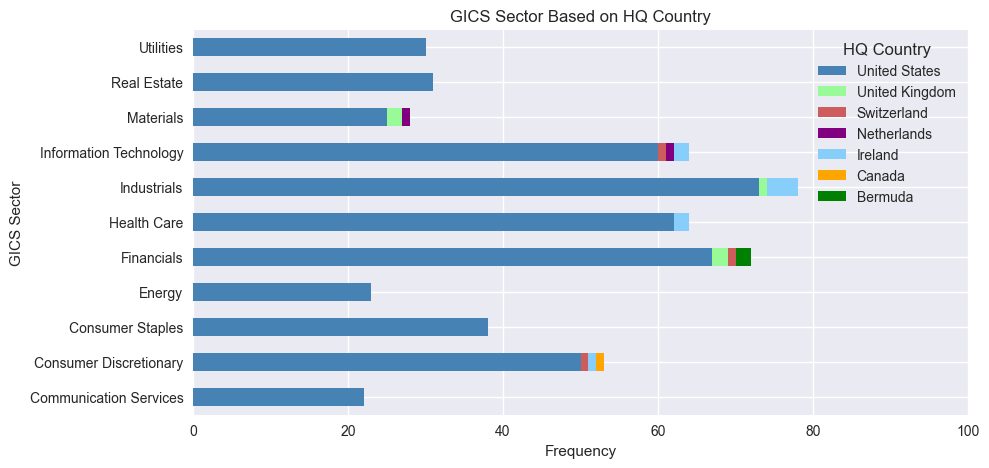

In [18]:
# linking HQ Country with GICS sector
table = SnP500_final_cleaned[['GICS Sector','HQ Country']].groupby(by=['GICS Sector']).value_counts()
table = pd.pivot_table(SnP500_final_cleaned[['GICS Sector','HQ Country']], values='HQ Country', index=['GICS Sector'],
                       columns=['HQ Country'], aggfunc="value_counts")
table = table.reindex(sorted(table.columns, reverse=True), axis=1)
ax = table.plot.barh(stacked=True, color={
    "United States": "steelblue",
    "United Kingdom": "palegreen",
    "Switzerland": "indianred", 
    "Netherlands": "purple",
    "Israel": "khaki", 
    "Ireland":"lightskyblue", 
    "Canada": "orange",
    "Bermuda": "green"})

ax.set_title('GICS Sector Based on HQ Country')
ax.set_xlabel("Frequency")
ax.set_xlim(0,100)

As seen in the above bar chart, most of these sectors are dominated by companies located in the United States. Utilities, Real Estate, Energy, Consumer Staples and Communication Services are GICS sectors where none of the companies are located outside of the United States. S&P500 companies located in the UK are primarily split across Materials and Financials, with some involvement in Industrials. Surprisingly, S&P500 companies located in Bermuda has about the same share as the UK in the Financials sector. 

In [88]:
# looking into the company located in Bermuda
SnP500_final_cleaned[SnP500_final_cleaned['HQ Country']=="Bermuda"]

,Symbol,Company,GICS Sector,HQ Country,HQ State/City,Market Cap / B,Revenue (TTM) / B,Profit Margin / %,Earnings per Share (TTM) / $,Price to Earning ratio (TTM),Payout ratio / %,Recommendation Score
280,ACGL,Arch Capital Group,Financials,Bermuda,Hamilton,27.72,12.73,23.32,7.75,9.59,0.00,2.1
406,EG,Everest Re,Financials,Bermuda,Hamilton,15.34,14.15,15.61,54.10,6.53,12.38,1.8


Both of these companies are part of the insurance sector, specifically in reinsurance services, which what Bermuda is well known for.

S&P500 companies in Ireland are split across Information Technology, Industrials, Health Care and Consumer Discretionary. Companies in Switzerland are split across Information Technology, Financials and Consumer Discretionary. Companies in canada only have contribution in Communication Services. Companies in Netherlands is divided amongst the Materials and Information Technology.  

### Columns: Market Cap, Revenue, Profit Margin, Earnings per Share, Price to Earning ratio, Payout ratio, Recommendation Score

In [133]:
# exploring  statiscal summary of all numerical feature
df = SnP500_final_cleaned[['Market Cap / B', 'Revenue (TTM) / B', 'Profit Margin / %', 'Earnings per Share (TTM) / $', 'Price to Earning ratio (TTM)','Payout ratio / %','Recommendation Score']]
stats_summary = df.describe()
df.describe()

,Market Cap / B,Revenue (TTM) / B,Profit Margin / %,Earnings per Share (TTM) / $,Price to Earning ratio (TTM),Payout ratio / %,Recommendation Score
count,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000
mean,88.171571,32.521769,13.678111,7.894036,27.041093,158.060557,2.314314
std,244.286191,64.238104,15.061325,23.850538,36.391610,1892.729718,0.366465
min,6.500000,0.730000,-165.730000,-28.880000,-309.000000,0.000000,1.500000
25%,17.625000,6.115000,6.975000,2.175000,13.465000,10.265000,2.000000
50%,33.770000,13.000000,11.910000,4.950000,23.370000,32.960000,2.300000
75%,69.525000,27.825000,20.595000,8.535000,34.000000,59.590000,2.600000
max,2990.000000,638.790000,87.170000,475.330000,325.390000,41200.000000,3.500000


There are some key statistics in the above table which suggest the possiblity of outliers due to errors. These statistics are:
- max values in ***Market Cap*** and ***Payout ratio***
- min values in ***Profit Margin***, ***Earnings per Share*** and ***Price to Earning ratio***

This poses the third question about our dataset:

#### <font color=red>3. Which companies are outliers in each of the 7 numerical features?</font>
- How many outliers in each of the numerical features
- Are these outliers due to any erraneous data
- Are there any recurring companies flagged as outliers
- What GICS sector has the most outlier

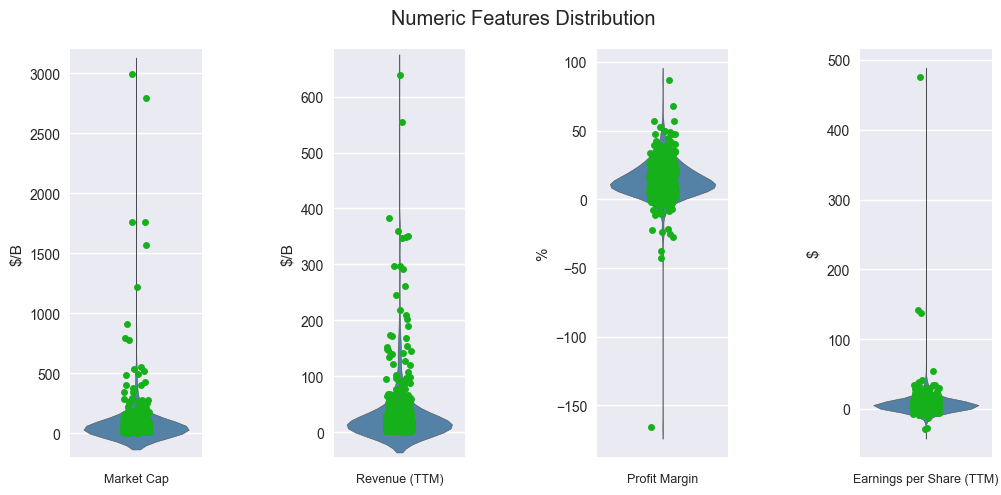

In [134]:
# plotting violin plot to visualise distribution and stripplot to view outliers
# splitting data to visualize the violint plots better across two figures
df_1 = df[['Market Cap / B', 'Revenue (TTM) / B', 'Profit Margin / %', 'Earnings per Share (TTM) / $']]
fig, ax = plt.subplots(1,4)
fig.tight_layout()
for i, column in enumerate(list(df_1.columns)): 
    if column[-1]=="B":
        units = "$/B"
    else:
        units = column[-1]
    plt.subplot(1,4,i+1)
    sns.violinplot(data = SnP500_final_cleaned[column], color = "steelblue")
    sns.stripplot(data = SnP500_final_cleaned[column], color = "#15b01a")
    ax[i].set_xlabel(column[:-4], fontsize=9)
    ax[i].set_ylabel(units)

ax[0].set_ylim(-200,3200)
ax[1].set_ylim(-45,685)
plt.suptitle("Numeric Features Distribution")
plt.subplots_adjust(top=0.9, wspace=1)

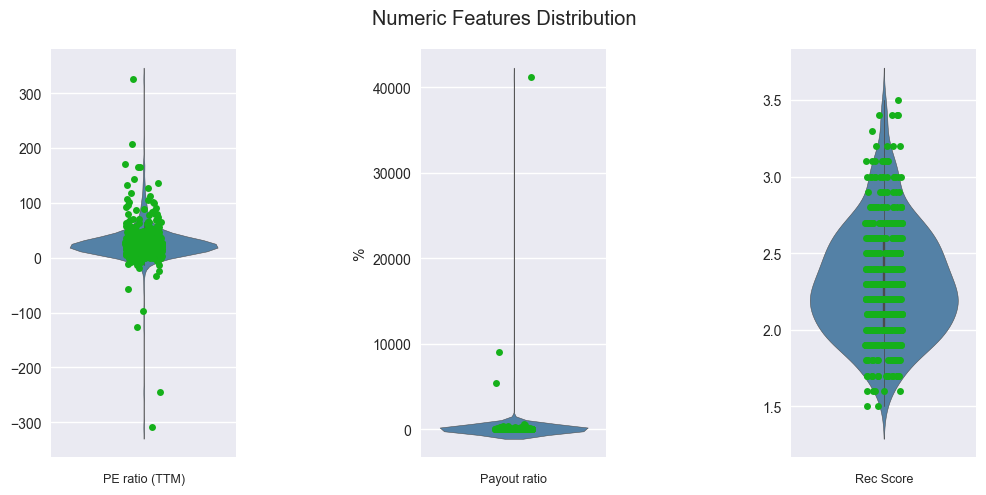

In [135]:
# plotting violin plot to visualise distribution and stripplot to view outliers
df_2 = df[['Price to Earning ratio (TTM)','Payout ratio / %','Recommendation Score']]
fig, ax = plt.subplots(1,3)
fig.tight_layout()
for i, column in enumerate(list(df_2.columns)): 
    if column[-1]!="%":
        units=""
    else:
        units = column[-1]
    plt.subplot(1,3,i+1)
    sns.violinplot(data = SnP500_final_cleaned[column], color = "steelblue")
    sns.stripplot(data = SnP500_final_cleaned[column], color = "#15b01a")
    if column == "Price to Earning ratio (TTM)":
        column = "PE ratio (TTM)"
    elif column == "Payout ratio / %":
        column = "Payout ratio"
    else:
        column = "Rec Score"
    ax[i].set_xlabel(column, fontsize=9)
    ax[i].set_ylabel(units)
    
plt.suptitle("Numeric Features Distribution")
plt.subplots_adjust(top=0.9, wspace=1)

In [140]:
# using 3 sigma rule to identify outliers and then highlighting the companies, GICS sector and value to confirm if outlier
# is due to any error in data
outlier = []
cumulative_outlier_cat = []
for column in list(df.columns):
    std = stats_summary[column][2]
    mean = stats_summary[column][1]
    upper_limit = mean+(3*std)
    lower_limit = mean-(3*std)
    cond1 = SnP500_final_cleaned[column]>upper_limit
    cond2 = SnP500_final_cleaned[column]<lower_limit
    add_company = SnP500_final_cleaned['Company'][cond1|cond2]
    add_GICS = SnP500_final_cleaned['GICS Sector'][cond1|cond2]
    print(SnP500_final_cleaned[['Company','GICS Sector', column]][cond1|cond2])
    outlier.extend(add_company)
    cumulative_outlier_cat.extend(add_GICS)

                   Company             GICS Sector  Market Cap / B
0               Apple Inc.  Information Technology         2990.00
1                Microsoft  Information Technology         2790.00
2  Alphabet Inc. (Class A)  Communication Services         1760.00
3  Alphabet Inc. (Class C)  Communication Services         1760.00
4                   Amazon  Consumer Discretionary         1570.00
5                   Nvidia  Information Technology         1220.00
6           Meta Platforms  Communication Services          909.77
                     Company             GICS Sector  Revenue (TTM) / B
0                 Apple Inc.  Information Technology             383.29
2    Alphabet Inc. (Class A)  Communication Services             297.13
3    Alphabet Inc. (Class C)  Communication Services             297.13
4                     Amazon  Consumer Discretionary             554.03
8         Berkshire Hathaway              Financials             349.25
13        UnitedHealth Group    

C:\Users\rajdh\AppData\Local\Temp\ipykernel_38980\3079365280.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  std = stats_summary[column][2]
C:\Users\rajdh\AppData\Local\Temp\ipykernel_38980\3079365280.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mean = stats_summary[column][1]
C:\Users\rajdh\AppData\Local\Temp\ipykernel_38980\3079365280.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  std = stats_summary[column][2]
C:\

Companies which are considered to be outliers for ***Market Cap*** are the top 7 companies with the largest ***Market Cap***. Given how large these companies are, their ***Market Cap*** is expected to be unsually large as well and therefore these are outliers due to their exceptional size and performance within their respective ***GICS Sector***. Similary, the 12 companies which are considered as outliers as per their ***Revenue*** are the top 12 largest revenues. It is worth highlighting that the 4 of these 12 companies have also the largest ***Market Cap***.

Looking at the ***Profit Margin***, the three negative values seem to be erraneous as one would expect to have a positive profit margin if a company is listed as one of S&P500 companies. After cross checking these values with another stocks information website, these values are accurate. The only logical explanation to negative profit margins, is rising cost.

Looking at the ***Earnings per Share***, NVR, Inc.'s $475 per share is exceptionally high. Researching into the company, again the the value is not erraneous. Extremely high EPS can be resulted in two ways, increasing the earnings or by reducing the share count through share buy backs. Looking at volumes of share traded along the years, it is found that it has reduced from about 30K in 2013 to about 10K in 2023.

Looking at the ***Price to Earnings ratio***, the two values which stand out are Carnival's -309 and Stanley Black & Decker's -245. Negative values for PE ratios are possible but only if the sum of EPS values over the last 4 quarters nets to a negative value. Both of these have a negative EPS value of less than one, which in turn would cause their PE ratio to be large when their stock price would be divided by the earnings. 

Looking at ***Payout ratio***, both companies have extremely high ratios. Upon research, the value for Ventas is as correct when compared to other sites; however, for J.M. Smucker Company, the values of Payout ratios are inconsistent, hinting at a potentially erraneous value. Therefore, the entry of J.M. Smucker Company will be removed.

Looking at the ***Recomendation Score***, the only reason Franklin Templeton is classed as outlier is because of using the 3 sigma rule on a very narrow range of data. The normal range of values is from 1-5. However, Franklin Templeton is considered an outlier with respect to other S&P500 companies, because most S&P500 companies have a score of below 3. In other words, most companies at their worst are at hold position.

In [144]:
# checking if there are any recurring outliers
outlier = pd.Series(outlier)
unique_counts_outlier = outlier.value_counts()
unique_counts_outlier.head().to_frame().style.background_gradient(cmap='GnBu')

,count
Apple Inc.,2
Alphabet Inc. (Class A),2
Alphabet Inc. (Class C),2
Amazon,2
Cardinal Health,1


As seen in the above table, the top 4 companies which are identified as being outliers in 2 of the 5 numerical features, are in fact the top 5 S&P500 companies. This suggests that their values of Market Capitalisation and Revenue are well above of what is expected from a typical S&P500 company.

In [162]:
# identifying from which GICS sector do these outliers come from
cumulative_outlier_cat = pd.Series(cumulative_outlier_cat)
precentage = pd.Series(((cumulative_outlier_cat.value_counts()/SnP500_final_cleaned['GICS Sector'].value_counts())*100), name="Percentage")
unique_counts_outlier_cat = pd.concat([cumulative_outlier_cat.value_counts(),precentage.round(2)], axis=1)
unique_counts_outlier_cat.fillna(0)

,count,Percentage
Information Technology,7.0,10.94
Consumer Discretionary,7.0,13.21
Health Care,7.0,10.94
Communication Services,5.0,22.73
Consumer Staples,5.0,13.16
Real Estate,4.0,12.90
Financials,3.0,4.17
Industrials,2.0,2.56
Energy,1.0,4.35
Materials,0.0,0.00


As seen in the above table, 4 of top 5 GICS sector containing the most S&P500 companies have also the most outliers. However, looking at the percentage of outliers when compared to the number of S&P500 companies in each GISC sectors, it is evident that ***Communication Services*** has the largest proportion as outliers. This is because of companies Alphabet and Meta which have appeared as outliers in one or both of ***Market Cap*** and ***Revenue***. The rest of the ***GICS Sectors*** contain less than 14% of outliers. 

In [163]:
# removing J.M. Smucker Company as it could have erraneous value in Payout ratio
SnP500_final_cleaned.drop(labels=[433], axis=0)

,Symbol,Company,GICS Sector,HQ Country,HQ State/City,Market Cap / B,Revenue (TTM) / B,Profit Margin / %,Earnings per Share (TTM) / $,Price to Earning ratio (TTM),Payout ratio / %,Recommendation Score
0,AAPL,Apple Inc.,Information Technology,United States,California,2990.00,383.29,25.31,6.12,31.40,15.33,2.1
1,MSFT,Microsoft,Information Technology,United States,Washington,2790.00,218.31,35.31,10.30,36.44,26.36,1.7
2,GOOGL,Alphabet Inc. (Class A),Communication Services,United States,California,1760.00,297.13,22.46,5.23,26.76,0.00,1.9
3,GOOG,Alphabet Inc. (Class C),Communication Services,United States,California,1760.00,297.13,22.46,5.22,27.01,0.00,1.7
4,AMZN,Amazon,Consumer Discretionary,United States,Washington,1570.00,554.03,3.62,1.91,79.55,0.00,1.7
...,...,...,...,...,...,...,...,...,...,...,...,...
498,VFC,VF Corporation,Consumer Discretionary,United States,Colorado,7.31,11.39,-1.89,-0.55,-34.18,536.67,2.7
499,HAS,Hasbro,Consumer Discretionary,United States,Rhode Island,7.09,5.39,-10.33,-4.02,-12.73,325.58,1.9
500,WHR,Whirlpool Corporation,Consumer Discretionary,United States,Michigan,6.68,19.29,-8.37,-28.88,-4.12,103.91,3.2
501,MHK,Mohawk Industries,Consumer Discretionary,United States,Georgia,6.59,11.17,-4.88,-8.58,0.00,0.00,3.0


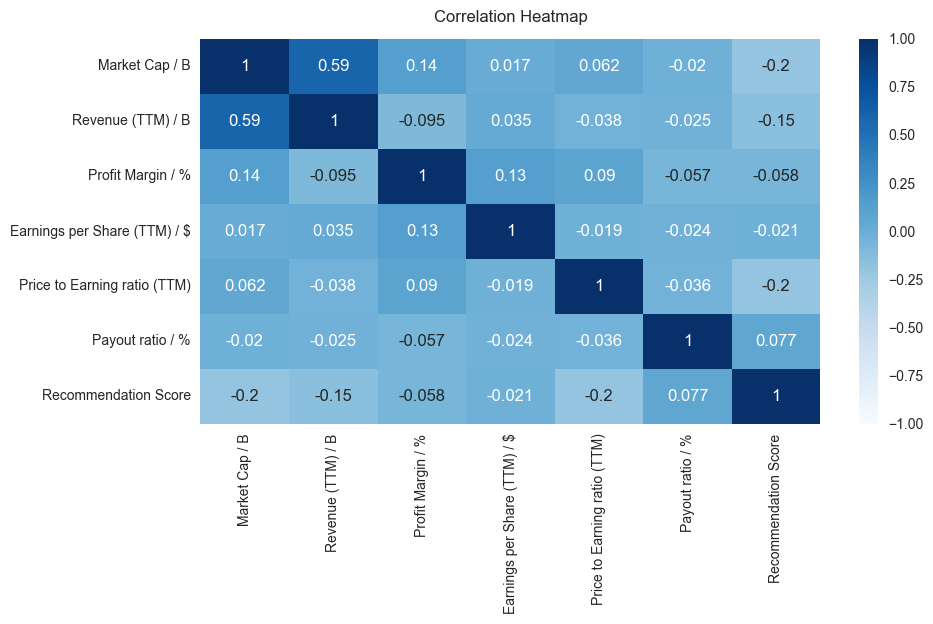

In [164]:
# exlporing correlation between the numerical features
df = SnP500_final_cleaned[['Market Cap / B', 'Revenue (TTM) / B', 'Profit Margin / %', 'Earnings per Share (TTM) / $', 'Price to Earning ratio (TTM)','Payout ratio / %','Recommendation Score']]
plt.figure(figsize=(10, 5))
sns.color_palette("Blues", as_cmap=True)
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap = "Blues")
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

As seen in the above figure, there is some correlation between ***Market Cap*** and ***Revenue***.

This leads to the 4th question:
#### <font color=red>4. What is the relationship between Market Capitilisation and Revenue?</font>
- Using hypothesis testing to check if the correlation coefficient is valid?
- Using regression, to find the relationship (linear, quadratic etc) between the two variables


## Step 5: Conclusion
***
[TODO placeholder]